### Data creation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
# Read the file with the raw data in a pandas dataframe

grades_df = pd.DataFrame(pd.read_csv("data/grades.csv"))
file_name_bi = "data/ALL_COURSES_MOD_TS_BI.csv"
file_name = "data/ALL_COURSES_MOD_TS.csv"

In [3]:
# Parameters used to create the time series

# if yaer = True all the academic year is considered
year = True 

# if year = False you can choose which subinterval of weeks to consider
start = 1
end = 17

# if mod = True the MOD students are considered
mod = True

# if topic = False the mean of all the subjects is computed 
# otherwise you can specify a topic between ["ENG", "MTH", "LAN", "OTR", "SCi", "SOC"]
topic = False

In [4]:
# Adjust the week number according to the acaemic year
# The first week of the academic year will be Week 1 and so on...

def rebase(d):
    begin = 35
    if d >= begin:
        return d - begin + 1
    else:
        return d + 53 - begin + 1
    
grades_df["assignment_date"] = grades_df.loc[:, "assignment_date"].apply(lambda d: rebase(d))

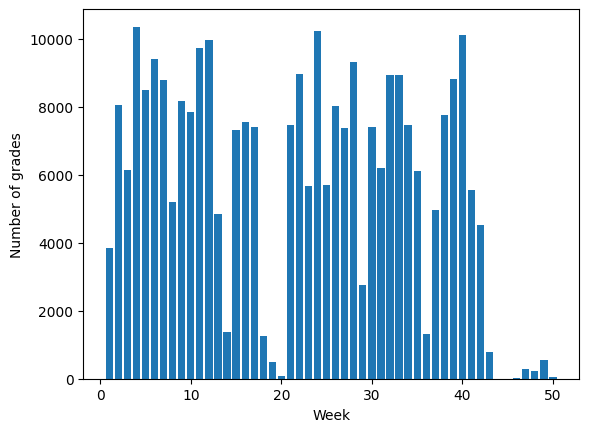

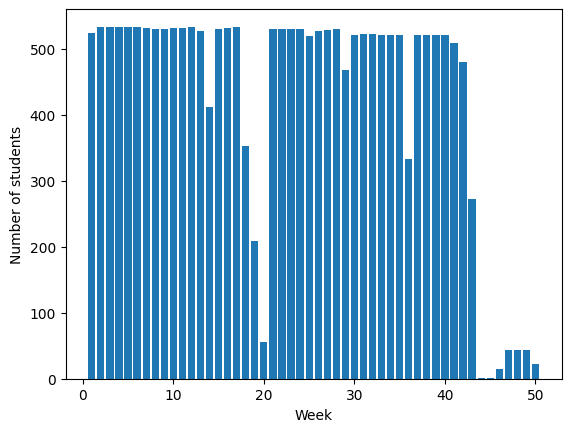

In [5]:
#Statistics on grades

temp = grades_df[grades_df['score'].notna()][["person_number", "assignment_date"]]

# Calculate the number of grades per week
grades_per_week = temp.groupby(["assignment_date"], as_index=False).count()
plt.bar(grades_per_week["assignment_date"], grades_per_week["person_number"])
plt.ylabel("Number of grades")
plt.xlabel("Week")
plt.show()

# Calculate the number of students with at least one grade per week
students_per_week = temp.groupby(["person_number", "assignment_date"], as_index=False).count()
students_per_week = students_per_week.groupby(["assignment_date"], as_index=False).count()
plt.bar(students_per_week["assignment_date"], students_per_week["person_number"])
plt.ylabel("Number of students")
plt.xlabel("Week")
plt.show()

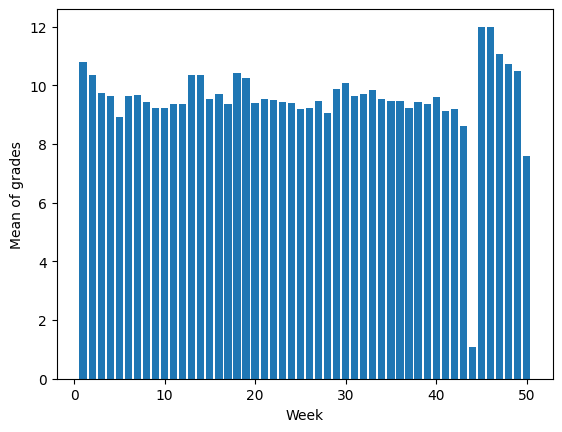

In [6]:
# Calculate the mean of the grades per week

grade_to_num = {'A+': 12, 'A': 11, 'A-': 10, 'B+': 9, 'B': 8, 'B-': 7,
                   'C+': 6, 'C': 5, 'C-': 4, 'D+':3, 'D':2, 'D-':1, 'F':0}

def mean_grade(grades_df):
    grades_df = grades_df[grades_df['score'].notna()][['assignment_date', 'point_range', 'score']]
    grades_df['numerical_score'] = grades_df['score'].apply(lambda grade_val: grade_to_num[grade_val])
    grades_df['normalized_score'] = grades_df.apply(lambda row: ((row['numerical_score'] * row['point_range'])), axis=1)
    mean_per_week = grades_df.groupby(['assignment_date'], as_index=False).sum()
    mean_per_week['mean'] = mean_per_week.apply(lambda row: ((row['normalized_score']) / row['point_range']), axis= 1)
    return mean_per_week

mean_per_week = mean_grade(grades_df)
plt.bar(mean_per_week["assignment_date"], mean_per_week["mean"])
plt.ylabel("Mean of grades")
plt.xlabel("Week")
plt.show()

In [7]:
# Student with "MOD" grades could be more affected by emotional issues

# Calculate the percentage of "MOD" grades
mod_grades = grades_df[(grades_df['score'].notna()) & (grades_df["course_level"] == "MOD")]
display(len(mod_grades)/len(grades_df[(grades_df['score'].notna())]))

# Calculate the number of students that have "MOD" grades
mod_students = mod_grades["person_number"].unique()
display(len(mod_students))

# Check if the students with "MOD" grades also have normal grades
no_mod_grades = grades_df[grades_df["course_level"] != "MOD"]
mod_no_mod_students = no_mod_grades[no_mod_grades["person_number"].isin(mod_students)]["person_number"].unique()
display(len(mod_no_mod_students))

0.02835529370894615

82

82

([<matplotlib.patches.Wedge at 0x25963809690>,
 [Text(0.9506711213316562, 0.5533754774707781, 'ENG'),
  Text(0.20270774916976436, 1.0811612129680421, 'LAN'),
  Text(-0.5273901259975162, 0.9653287807790277, 'MTH'),
  Text(-1.0369821947905877, -0.36697129000413087, 'OTR'),
  Text(0.22964814196163053, -1.0757610008238685, 'SCI'),
  Text(0.9218040001035873, -0.6002311099843342, 'SOC'),
  Text(1.0956384188350838, -0.09785936425584155, 'nan')],
 [Text(0.5185478843627215, 0.3018411695295153, '16.8%'),
  Text(0.11056786318350782, 0.5897242979825683, '10.5%'),
  Text(-0.2876673414531906, 0.5265429713340151, '11.3%'),
  Text(-0.5656266517039569, -0.20016615818407135, '33.6%'),
  Text(0.1252626228881621, -0.58677872772211, '12.2%'),
  Text(0.502802181874684, -0.3273987872641822, '12.7%'),
  Text(0.5976209557282275, -0.05337783504864084, '2.8%')])

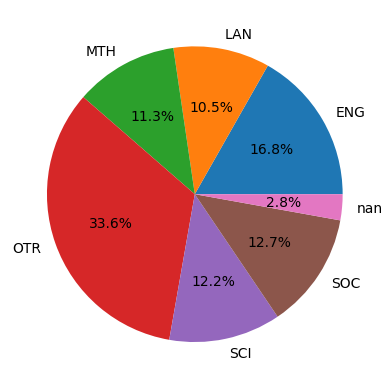

In [8]:
# Calculate the percentge of grades for each topic
# The topic "nan" corresponds to "MOD" grades

topic_grades = grades_df[grades_df['score'].notna()][['course_category']]
topic_grades["count"] = 1
topic_grades = topic_grades.groupby(["course_category"], as_index=False, dropna=False).sum()
plt.pie(topic_grades['count'], labels=topic_grades['course_category'], autopct='%1.1f%%')

In [9]:
grade_to_num = {'A+': 12, 'A': 11, 'A-': 10, 'B+': 9, 'B': 8, 'B-': 7,
                   'C+': 6, 'C': 5, 'C-': 4, 'D+':3, 'D':2, 'D-':1, 'F':0}

def get_student_grades_time_series(grades_df):
    # Clean DataFrame
    grades_df = grades_df[grades_df['score'].notna()]
    grades_df = grades_df[['person_number', 'academic_year', 'course_category', 'assignment_date', 'point_range', 'score']]

    # Normalize each score and weight it to its point_range
    grades_df['numerical_score'] = grades_df['score'].apply(lambda grade_val: grade_to_num[grade_val])
    grades_df['normalized_score'] = grades_df.apply(lambda row: row['numerical_score'] * row['point_range'], axis=1)

    # Get total points for each week
    if mod:
        #dropna=False allow to consider "MOD" grades as an additional subject
        student_weekly_grades_sum = grades_df.groupby(['person_number', 'academic_year', 'course_category', 'assignment_date'], as_index=False, dropna=False).sum()
    else:
        student_weekly_grades_sum = grades_df.groupby(['person_number', 'academic_year', 'course_category', 'assignment_date'], as_index=False).sum()
        
    # Normalize score for each week by dividing points scored by total points
    student_weekly_grades_sum['final_score'] = student_weekly_grades_sum.apply(lambda row: ((row['normalized_score']) / row['point_range']), axis= 1)
    time_series_df = student_weekly_grades_sum[['person_number', 'academic_year', 'course_category',
                                                      'assignment_date', 'final_score']]
    return time_series_df

In [10]:
# Calculate the final normalized score for each row

time_series_df = get_student_grades_time_series(grades_df)
display(time_series_df.head())
display(len(time_series_df))

,person_number,academic_year,course_category,assignment_date,final_score
0,1,2122,ENG,2,8.500000
1,1,2122,ENG,3,12.000000
2,1,2122,ENG,4,7.338843
3,1,2122,ENG,5,8.322034
4,1,2122,ENG,6,12.000000


61857

In [11]:
# Filter weeks and move grades entered during a break in the week before with enough grades
# The idea is that grades inserted in the breaks could be referred to weeks before

accept = []
high_threshold = 0.9 * len(time_series_df['person_number'].unique())
low_threshold = 0.1 * len(time_series_df['person_number'].unique())
display(high_threshold)
display(low_threshold)

last_accepted = 0
for i in range(1, 53):
    if len(students_per_week[students_per_week["assignment_date"] == i]["person_number"]) > 0:
        if students_per_week[students_per_week["assignment_date"] == i]["person_number"].values[0] > high_threshold:
            accept.append(i)
            last_accepted = i
        elif i-1 in accept:
            if len(students_per_week[students_per_week["assignment_date"] == i]["person_number"]) > 0:
                if students_per_week[students_per_week["assignment_date"] == i]["person_number"].values[0] > low_threshold:
                    accept.append(i)
                    time_series_df.loc[time_series_df["assignment_date"] == i, "assignment_date"] = last_accepted
                    
time_series_df = time_series_df[time_series_df["assignment_date"].isin(accept)]
if not year:
    time_series_df = time_series_df[(time_series_df['assignment_date'] >= start) & (time_series_df['assignment_date'] <= end)]

486.90000000000003

54.1

In [12]:
# Calculate for each student the final score for each week

if topic:
    time_series_df = time_series_df[time_series_df["course_category"] == topic]
time_series_df["count"] = 1
time_series_to_extract = time_series_df.groupby(["person_number", "academic_year", "assignment_date"], as_index=False).sum()
time_series_to_extract["final_score"] = time_series_to_extract["final_score"]/time_series_to_extract["count"]
display(time_series_to_extract.head())

,person_number,academic_year,assignment_date,final_score,count
0,1,2122,1,12.000000,3
1,1,2122,2,8.125000,4
2,1,2122,3,10.150000,4
3,1,2122,4,9.147211,4
4,1,2122,5,7.916149,5


In [13]:
students_subset = time_series_to_extract['person_number'].unique().tolist()
weeks_subset = sorted(time_series_to_extract['assignment_date'].unique().tolist())

In [14]:
# Construct the time series, one for each student

time_series = pd.DataFrame(columns=range(len(weeks_subset)), index=students_subset)

for student_idx, student in enumerate(students_subset):
    student_time_series = time_series_to_extract[time_series_to_extract['person_number'] == student][['assignment_date', 'final_score']]
    for _, row in student_time_series.iterrows():
        time_series.iloc[student_idx, weeks_subset.index(row["assignment_date"])] = float(row['final_score'])
display(time_series.shape)

(539, 35)

'Total number of Nan: 419.0'

'Average number of Nan per student: 0.7773654916512059'

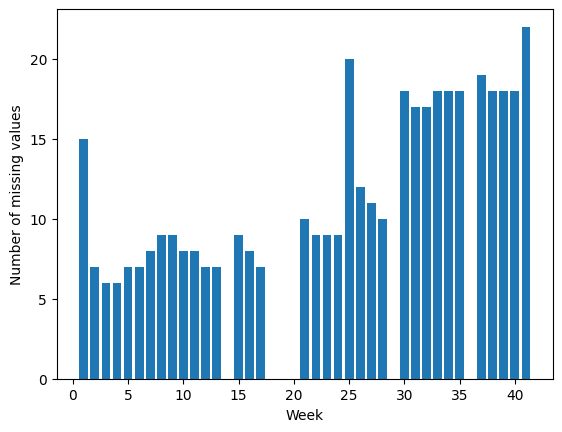

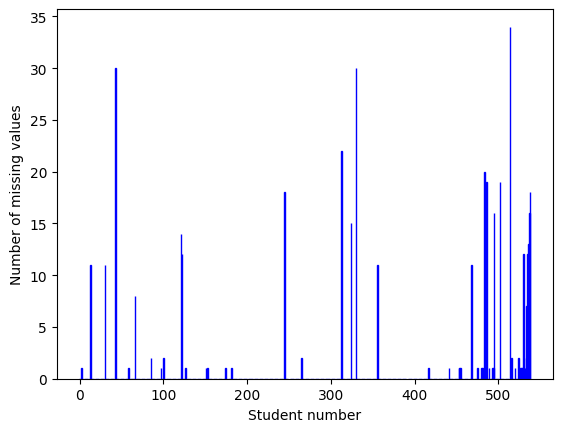

In [15]:
# Statistics on missing values

nan_per_student = np.zeros(len(time_series))
nan_per_week = np.zeros(len(time_series.columns))
id = 0
for _, row in time_series.iterrows():
    for i, x in enumerate(row):
        if pd.isna(x):
            nan_per_week[i] += 1
            nan_per_student[id] += 1
    id += 1
    
    
# Number of missing values per week
perc = sum(nan_per_week)/len(time_series)
display("Total number of Nan: " + str(sum(nan_per_week)))
display("Average number of Nan per student: " + str(perc))
plt.bar(weeks_subset, nan_per_week)
plt.ylabel("Number of missing values")
plt.xlabel("Week")
plt.show()

# Number of missing values per student
plt.bar(range(len(time_series)), nan_per_student, ec='blue')
plt.ylabel("Number of missing values")
plt.xlabel("Student number")
plt.show()

In [16]:
# Remove series with more than 25% of missing values

display(len(time_series))
drop = []
for i in range(len(nan_per_student)):
    if nan_per_student[i] > 0.25 * len(time_series.columns):
        drop.append(time_series.index[i])
time_series = time_series.drop(drop)
display(len(time_series))

539

518

'Total number of Nan: 55.0'

'Average number of Nan per student: 0.10617760617760617'

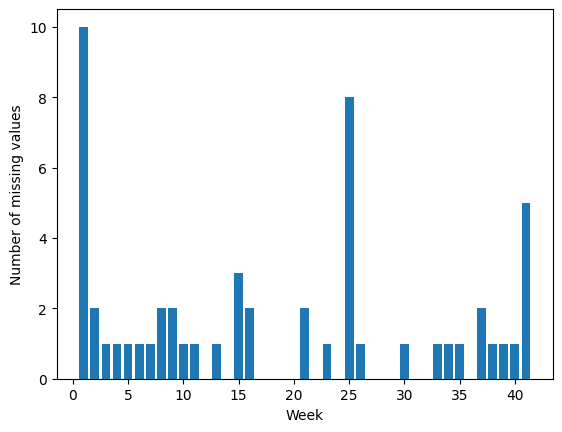

In [17]:
# Calcuate the number of missing values remaining

nan_per_week = np.zeros(len(time_series.columns))
nan_ts = time_series.loc[(pd.isna(time_series)).any(axis=1)]
for _, row in nan_ts.iterrows():
    for i, x in enumerate(row):
        if pd.isna(x):
            nan_per_week[i] += 1
perc = sum(nan_per_week)/len(time_series)
display("Total number of Nan: " + str(sum(nan_per_week)))
display("Average number of Nan per student: " + str(perc))
plt.bar(weeks_subset, nan_per_week)
plt.ylabel("Number of missing values")
plt.xlabel("Week")
plt.show()

In [18]:
# Save file of time series with missing values
time_series.to_csv(file_name_bi)

In [19]:
# Interpolate missing values with linear interpolation

time_series = time_series.astype('float').interpolate(method="linear", axis=1, order=1, limit_direction="both").dropna()
display(len(time_series))

518

In [20]:
# Save file of time series without missing values
time_series.to_csv(file_name)

### Data preprocessing

In [21]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random as rd

In [22]:
file_name = "data/ALL_COURSES_MOD_TS.csv"
time_series = pd.read_csv(file_name, index_col=0)

In [23]:
# Function to visualize student time series

def visualize_stud_data(df, gridcol :int, gridrow = None, ybottom = -1, ytop = 13, random = []):
    
    if not gridrow: 
        gridrow = math.ceil(30/gridcol)
    n = min(len(df), gridrow*gridcol)
    length = 18
    width = (length/gridcol)*gridrow/2
    
    fig, axes = plt.subplots(nrows = gridrow, ncols = gridcol, figsize=(length, width), sharex=False, sharey=False)
    
    for ax in axes.flat:
        ax.set(xlabel='Week', ylabel='Grade')

    # Hide x labels and tick labels for top plots and y ticks for right plots
    for ax in axes.flat:
        ax.label_outer()
    
    for i in range(n):
        if len(random) > 0:
            axes.flat[i].plot(range(len(df.columns)), df.iloc[random[i]])
            axes.flat[i].set_title('Student ' + str(random[i] + 1))
        else:
            axes.flat[i].plot(range(len(df.columns)), df.iloc[i])
            axes.flat[i].set_title('Student ' + str(i + 1))
        axes.flat[i].set_ylim(bottom=ybottom, top=ytop)
    plt.show()

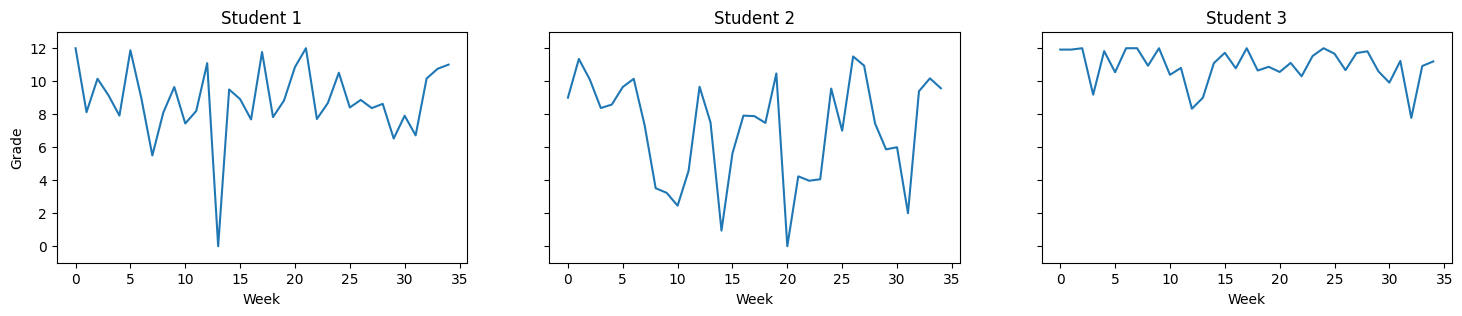

In [24]:
# Student time series without preprocessing

visualize_stud_data(time_series, gridcol=3, gridrow=1)

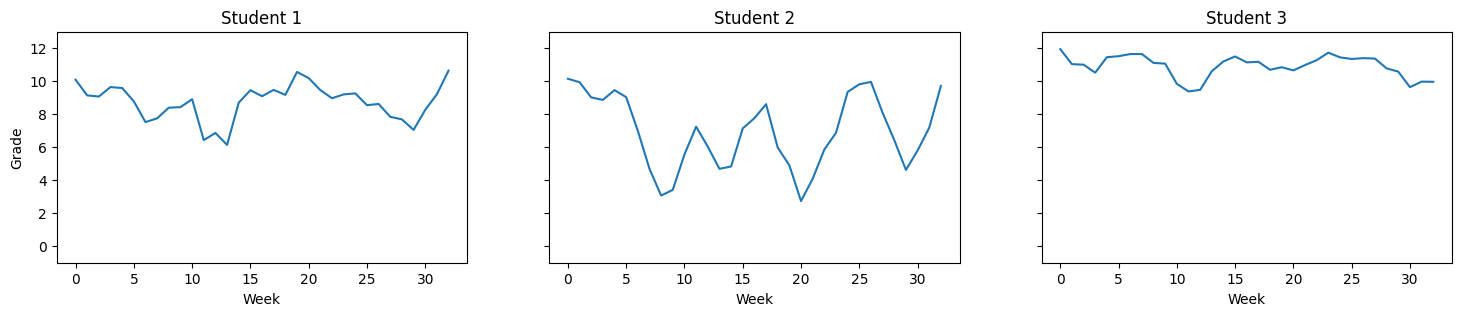

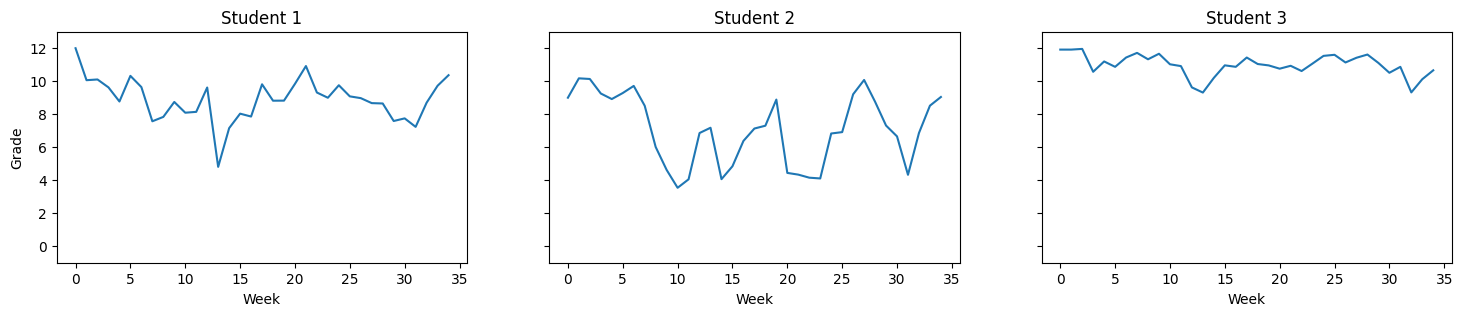

In [25]:
# Data smooothing

window = 3
alpha = 0.5

# Student time series after moving average with window size = 3
ma_time_series = (time_series.T.rolling(window).mean()).T.iloc[:,window-1:]
visualize_stud_data(ma_time_series, gridcol=3, gridrow=1)

# Student time series after exponential moving average with alpha = 0.5
ema_time_series = time_series.ewm(axis=1, alpha=alpha, adjust=False).mean()
visualize_stud_data(ema_time_series, gridcol=3, gridrow=1)

In [26]:
processed_time_series = ma_time_series

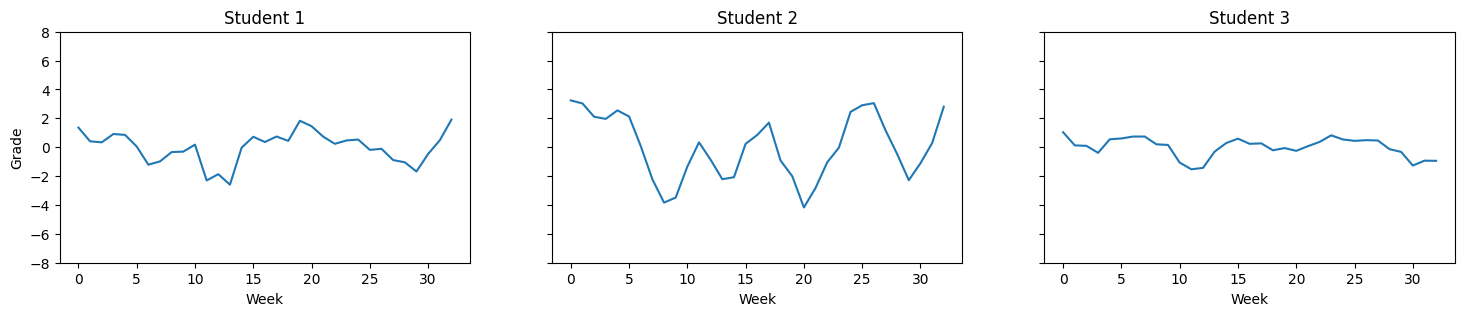

In [27]:
# Delta averaging
i = 0
for _, row in processed_time_series.iterrows():
    s = 0
    for x in row:
        s += x
    mean = float(s/len(row))
    for j, x in enumerate(row):
        processed_time_series.iloc[i, j] = float((x - mean))
    i += 1
        
# Student time series after moving average with window size = 3 and delta averaging
visualize_stud_data(processed_time_series, gridcol=3, gridrow=1, ybottom=-8, ytop=8)

### DTW

In [28]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

x=rd.randint(0, len(time_series))
y=rd.randint(0, len(time_series))

'Euclidean distance: 19.302343781822177'

'DTW distance: 11.445389495897256'

(<Figure size 1000x1000 with 4 Axes>,
 [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>])

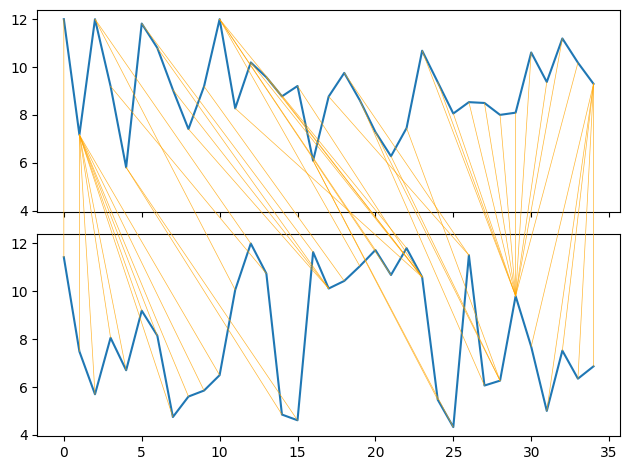

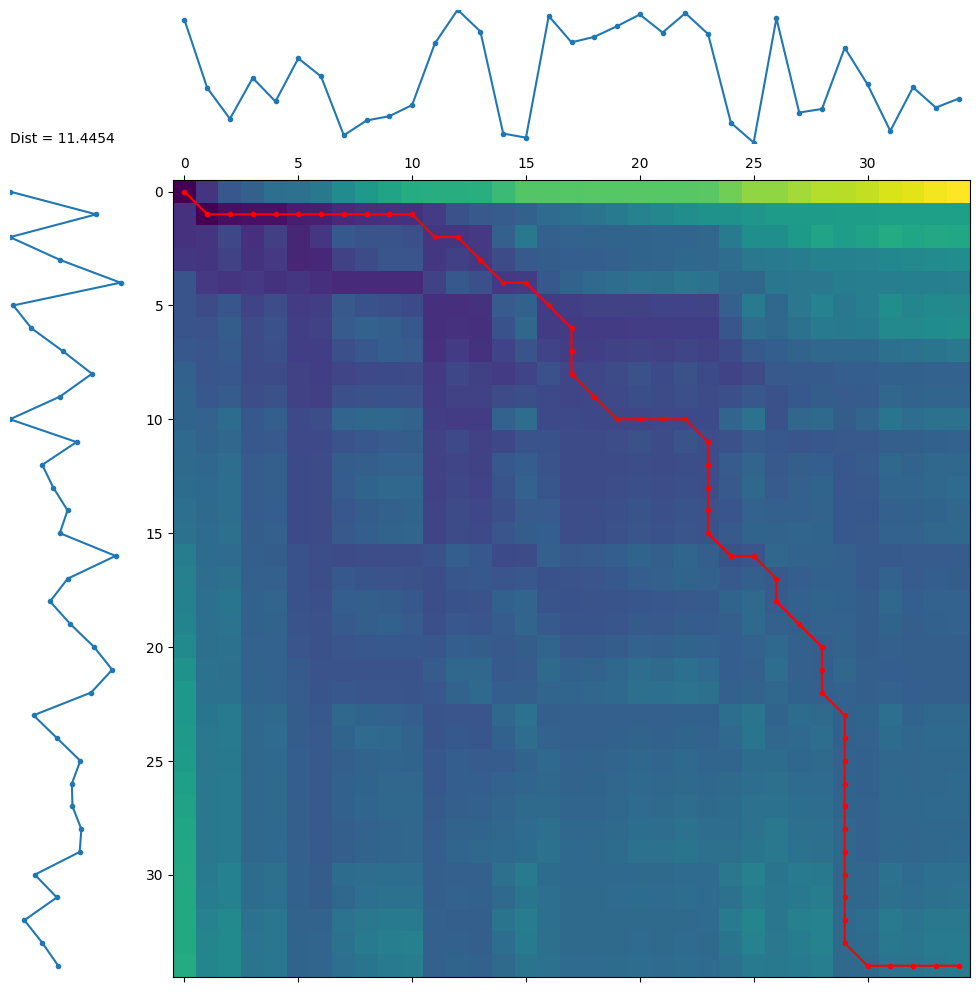

In [29]:
# Example to show how DTW works
#DTW is always lower than Euclidean distance

s1 = time_series.iloc[x].to_numpy(dtype=np.double)
s2 = time_series.iloc[y].to_numpy(dtype=np.double)

eu_distance = np.sqrt(np.sum(np.square(s1 - s2)))
display("Euclidean distance: " + str(eu_distance))
dtw_distance = dtw.distance_fast(s1, s2, use_pruning=True)
display("DTW distance: " + str(dtw_distance))

path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path)

d, paths = dtw.warping_paths(s1, s2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, path)